# Data loading and libraries loading


In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
url = "https://raw.githubusercontent.com/AnnaRemi/Lab_trajectiories/main/_sessions/Test/SM1_B0A104.csv"

In [3]:
dataset = pd.read_csv(url)

In [4]:
dataset.head()

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
0,0.066284,-0.533936,0.815063,-1.663208,0.289917,1.922607
1,0.066162,-0.534058,0.815796,-1.663208,0.305176,1.922607
2,0.066650,-0.533447,0.815430,-1.663208,0.305176,1.907349
3,0.066528,-0.533569,0.815063,-1.678467,0.305176,1.907349
4,0.067871,-0.533325,0.814819,-1.678467,0.289917,1.892090


In [5]:
dataset.accel_x[0]

0.0662841796875

__Acceleration plot__

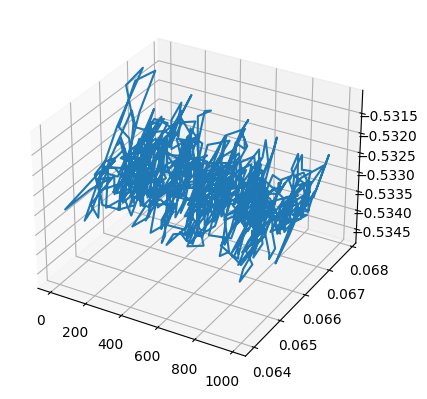

In [6]:
ax = plt.axes(projection='3d')
t = np.arange(0, dataset.accel_z.size, 1)
zline = dataset.accel_z
xline = dataset.accel_x
yline = dataset.accel_y
ax.plot3D(t, xline, yline, zline)

*Не слишком информативно(*

# Integration function


Here I'm going to approximate an integral by rectangles beneath the curve


In [7]:
def integrate(acceleration_data, times):
    accumulated_speed = 0.0

    last_time = times[0]
    speeds = []

    # Once again, we lose some data because we have to start
    #    at i=1 instead of i=0.
    for i in range(1, len(times)):

        # 4. Get the numbers for this index i
        acceleration = acceleration_data[i]
        time = times[i]

        # 5. Calculate delta t
        delta_t = time - last_time

        # 6. This is an important step! This is where we approximate
        #    the area under the curve using a rectangle w/ width of
        #    delta_t.
        delta_v = acceleration * delta_t

        # 7. The actual speed now is whatever the speed was before
        #    plus the new change in speed.
        accumulated_speed += delta_v

        # 8. append to speeds and update last_time
        speeds.append(accumulated_speed)
        last_time = time
    return speeds

# Gyro data explored

In [8]:
YAW_RATES = [dataset.gyro_x, dataset.gyro_y, dataset.gyro_z]
TIMESTAMPS    = np.arange(0, dataset.accel_z.size, 1)

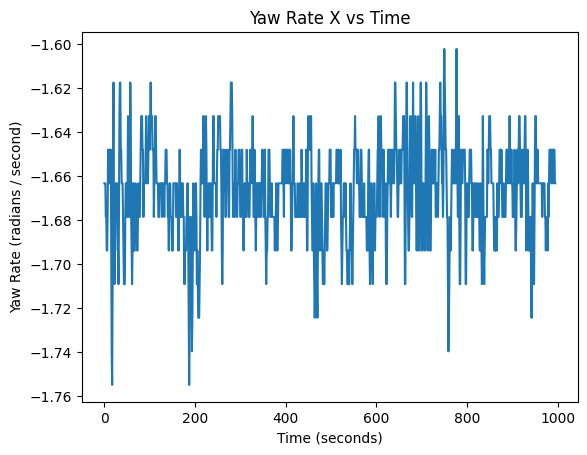

In [9]:
plt.title("Yaw Rate X vs Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Yaw Rate (radians / second)")
plt.plot(TIMESTAMPS, YAW_RATES[0])
plt.show()

In [10]:
def get_angle(YAW_RATES, TIMESTAMPS):
  thetas_x = integrate(YAW_RATES[0], TIMESTAMPS)
  thetas_y = integrate(YAW_RATES[1], TIMESTAMPS)
  thetas_z = integrate(YAW_RATES[2], TIMESTAMPS)

  ANGLES = [thetas_x, thetas_y, thetas_z]
  return ANGLES

In [45]:
ANGLES = get_angle(YAW_RATES, TIMESTAMPS)

In [81]:
len(YAW_RATES[0])

996

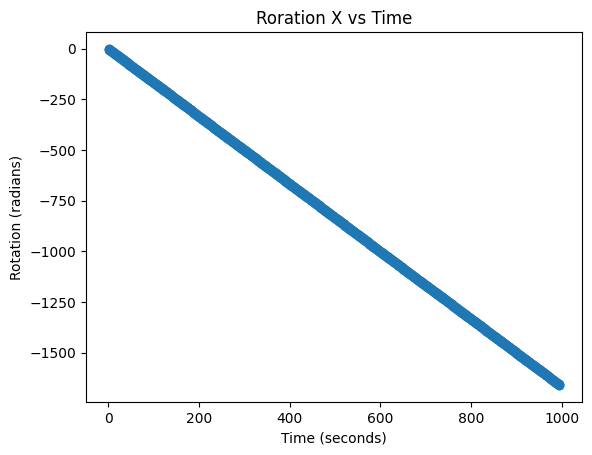

In [12]:
plt.title("Roration X vs Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Rotation (radians)")
plt.scatter(TIMESTAMPS[1:], ANGLES[0])
plt.show()

In [51]:
def get_rotation_matr(ANGLES):
  MATRICES = []

  for i in range(len(ANGLES[0])):
    alpha = ANGLES[0][i] #x
    beta = ANGLES[1][i] #y
    gamma = ANGLES[2][i] #z

    c, s = np.cos(alpha), np.sin(alpha)
    R_x = np.array([[1, 0, 0], [0, c, -s], [-s, 0, c]])

    c, s = np.cos(beta), np.sin(beta)
    R_y = np.array([[c, 0, s], [0, 1, 0], [0, s, c]])

    c, s = np.cos(gamma), np.sin(gamma)
    R_z = np.array([[c, 0, s], [0, 1, 0], [0, s, c]])

    temp = R_x.dot(R_y)
    MATRICES.append(temp.dot(R_z))

  return MATRICES

# Gyro and Accelerometer data combined

In [52]:
url = "https://raw.githubusercontent.com/AnnaRemi/Lab_trajectiories/main/_sessions/Test/SM1_B1A104.csv"
dataset_1 = pd.read_csv(url)

TIMESTAMPS    = np.arange(0, dataset.accel_z.size, 1)
YAW_RATES = [dataset_1.gyro_x, dataset_1.gyro_y, dataset_1.gyro_z]
ACCELERATIONS = [dataset.accel_x, dataset.accel_y, dataset.accel_z]

In [71]:
def callibrate(ACCELERATIONS, YAW_RATES, TIMESTAMPS):
  ANGLES = get_angle(YAW_RATES, TIMESTAMPS)
  MATRICES = get_rotation_matr(ANGLES)
  # print(len(MATRICES[0][0]))

  new_acc = [[], [], []]

  for i in range(len(MATRICES)):
    matrix = np.array(MATRICES[i])
    vector = np.array([ACCELERATIONS[0][i], ACCELERATIONS[1][i], ACCELERATIONS[2][i]])
    res = (matrix.dot(vector)).tolist()
    new_acc[0].append(res[0])
    new_acc[1].append(res[1])
    new_acc[2].append(res[2])

  return new_acc

In [55]:
def get_position(ACCELERATIONS, TIMESTAMPS):
  # Now we use the function we just defined
  integrated_speeds_x = integrate(ACCELERATIONS[0], TIMESTAMPS)
  integrated_displ_x = integrate(integrated_speeds_x,
                                                  TIMESTAMPS[1:])

  integrated_speeds_y = integrate(ACCELERATIONS[1], TIMESTAMPS)
  integrated_displ_y = integrate(integrated_speeds_y,
                                                  TIMESTAMPS[1:])

  integrated_speeds_z = integrate(ACCELERATIONS[2], TIMESTAMPS)
  integrated_displ_z = integrate(integrated_speeds_z,
                                                  TIMESTAMPS[1:])

  position = [integrated_displ_x, integrated_displ_y, integrated_displ_z]
  return position


In [56]:
def get_plot(x, y, z):
  ax = plt.axes(projection='3d')
  ax.plot3D(x, y, z)

In [75]:
ACCELERATIONS_NEW = callibrate(ACCELERATIONS, YAW_RATES, TIMESTAMPS)

In [82]:
position = get_position(ACCELERATIONS_NEW, TIMESTAMPS[1:])

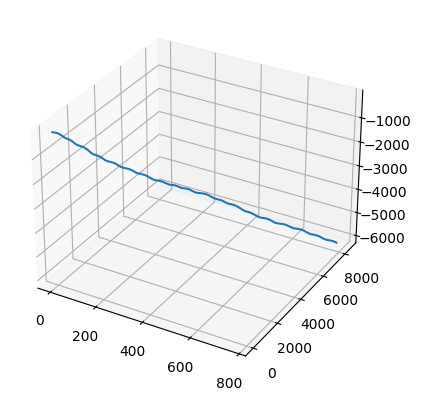

In [83]:
get_plot(position[0], position[1], position[2])

In [84]:
def plot_trajectory(ACCELERATIONS, YAW_RATES, TIMESTAMPS):
  ACCELERATIONS_NEW = callibrate(ACCELERATIONS, YAW_RATES, TIMESTAMPS)
  position = get_position(ACCELERATIONS_NEW, TIMESTAMPS[1:])
  get_plot(position[0], position[1], position[2])

# New Old Dataset


In [101]:
url = "https://raw.githubusercontent.com/AnnaRemi/Lab_trajectiories/main/_sessions/Test/SM1_B0A104.csv"
dataset_1 = pd.read_csv(url)

TIMESTAMPS    = np.arange(0, dataset_1.accel_z.size, 1)
YAW_RATES = [dataset_1.gyro_x, dataset_1.gyro_y, dataset_1.gyro_z]
ACCELERATIONS = [dataset_1.accel_x, dataset_1.accel_y, dataset_1.accel_z]

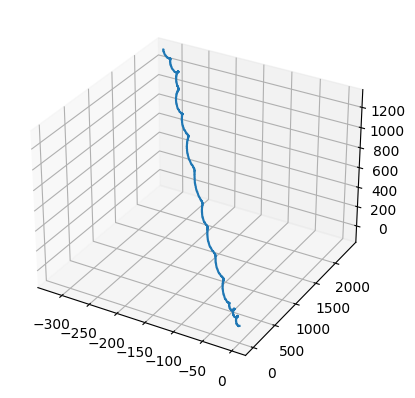

In [102]:
plot_trajectory(ACCELERATIONS, YAW_RATES, TIMESTAMPS)

# Anna's dataset 1

In [99]:
url = "https://raw.githubusercontent.com/AnnaRemi/Lab_trajectiories/main/_sessions/Anna_1/SM2_B0A104.csv"
dataset_1 = pd.read_csv(url)

TIMESTAMPS    = np.arange(0, dataset_1.accel_z.size, 1)
YAW_RATES = [dataset_1.gyro_x, dataset_1.gyro_y, dataset_1.gyro_z]
ACCELERATIONS = [dataset_1.accel_x, dataset_1.accel_y, dataset_1.accel_z]

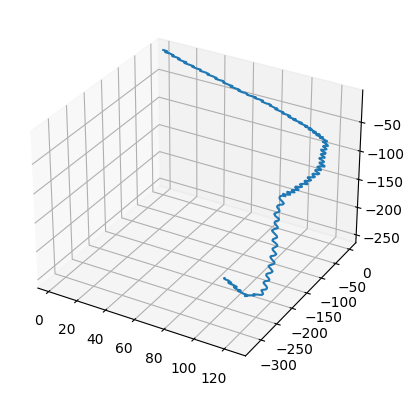

In [100]:
plot_trajectory(ACCELERATIONS, YAW_RATES, TIMESTAMPS)